In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Acknowledgment:
# This work builds upon the JacobiConv implementation developed by the GraphPKU team.
# For reference, see: https://github.com/GraphPKU/JacobiConv
# We extend our sincere gratitude to the authors for their valuable contributions.


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn.inits import glorot, zeros
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, auc
import math
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# === Load Patients ===
fa_patients_path = "/home/snu/Downloads/NIFD_Patients_FA_Histogram_Feature.npy"
Patients_FA_array = np.load(fa_patients_path, allow_pickle=True)

# === Load Controls ===
fa_controls_path = "/home/snu/Downloads/NIFD_Control_FA_Histogram_Feature.npy"
Controls_FA_array = np.load(fa_controls_path, allow_pickle=True)

print("Patients Shape:", Patients_FA_array.shape)
print("Controls Shape:", Controls_FA_array.shape)

# === Combine features and labels ===
X = np.vstack([Controls_FA_array, Patients_FA_array])
y = np.hstack([
    np.zeros(Controls_FA_array.shape[0], dtype=np.int64),  # 0 = Control
    np.ones(Patients_FA_array.shape[0], dtype=np.int64)    # 1 = Patient
])

# Shuffle
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

Patients Shape: (98, 180)
Controls Shape: (48, 180)


In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

num_nodes, num_feats = X.shape
print(f"Features: {X.shape}, Labels: {y.shape}")
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

Features: (146, 180), Labels: (146,)


In [5]:
alpha = 0
X_norm = F.normalize(X_tensor, p=2, dim=1)
sim_matrix = torch.mm(X_norm, X_norm.T)
src, dst = torch.where(sim_matrix > alpha)
mask = src != dst
src, dst = src[mask], dst[mask]

edge_index = torch.stack([src, dst], dim=0).to(device)

X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

print(f"Graph Nodes: {num_nodes}, Edges: {edge_index.size(1)}, Device: {device}")

Graph Nodes: 146, Edges: 9900, Device: cuda


In [6]:
class JacobiConv(MessagePassing):
    def __init__(self, in_channels, out_channels, K=3, alpha=1.0, beta=1.0,
                 normalization='sym', bias=True, **kwargs):
        kwargs.setdefault('aggr', 'add')
        super(JacobiConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.normalization = normalization

        self.weight = nn.Parameter(torch.Tensor(K + 1, in_channels, out_channels))

        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)

    def __norm__(self, edge_index, num_nodes, edge_weight=None, improved=False,
                 dtype=None):
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        fill_value = 2. if improved else 1.
        edge_index, edge_weight = add_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)

        row, col = edge_index
        deg = degree(col, num_nodes, dtype=edge_weight.dtype)

        if self.normalization == 'sym':
            deg_inv_sqrt = deg.pow(-0.5)
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
            return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        elif self.normalization == 'rw':
            deg_inv = deg.pow(-1.0)
            deg_inv[deg_inv == float('inf')] = 0
            return edge_index, deg_inv[row] * edge_weight
        else:
            return edge_index, edge_weight

    def compute_jacobi_coeffs(self, k):
        if k == 0:
            return 1.0, 0.0, 0.0
        elif k == 1:
            theta_k = (self.alpha + self.beta + 2) / 2
            theta_k_prime = (self.alpha - self.beta) / 2
            return theta_k, theta_k_prime, 0.0
        else:
            theta_k = (2 * k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 1) / (2 * k * (k + self.alpha + self.beta))
            theta_k_prime = (2 * k + self.alpha + self.beta - 1) * (self.alpha ** 2 - self.beta ** 2) / (2 * k * (k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 2))
            theta_k_double = (k + self.alpha - 1) * (k + self.beta - 1) * (2 * k + self.alpha + self.beta) / (k * (k + self.alpha + self.beta) * (2 * k + self.alpha + self.beta - 2))
            return theta_k, theta_k_prime, theta_k_double

    def forward(self, x, edge_index, edge_weight=None):
        edge_index, norm = self.__norm__(edge_index, x.size(0), edge_weight,
                                         dtype=x.dtype)

        Tx_0 = x
        #out = torch.einsum('ijk,jk->ik', self.weight[0:1], Tx_0.unsqueeze(0))
        out = Tx_0 @ self.weight[0]


        if self.K > 0:
            Tx_1 = (self.alpha - self.beta) / 2 * x + (self.alpha + self.beta + 2) / 2 * self.propagate(edge_index, x=x, norm=norm)
            #out += torch.einsum('ijk,jk->ik', self.weight[1:2], Tx_1.unsqueeze(0))
            out += Tx_1 @ self.weight[1]

        for k in range(2, self.K + 1):
            theta_k, theta_k_prime, theta_k_double = self.compute_jacobi_coeffs(k)
            Tx_2 = theta_k * self.propagate(edge_index, x=Tx_1, norm=norm) + theta_k_prime * Tx_1 - theta_k_double * Tx_0
            #out += torch.einsum('ijk,jk->ik', self.weight[k:k+1], Tx_2.unsqueeze(0))
            out += Tx_2 @ self.weight[k]
            Tx_0, Tx_1 = Tx_1, Tx_2

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def __repr__(self):
        return f'{self.__class__.__name__}({self.in_channels}, {self.out_channels}, K={self.K}, alpha={self.alpha}, beta={self.beta})'

In [7]:
class JacobiNet(nn.Module):
    """
    Multi-layer JacobiConv network for node classification

    Args:
        in_channels (int): Size of input features
        hidden_channels (int): Size of hidden representations
        out_channels (int): Number of output classes
        num_layers (int): Number of JacobiConv layers (default: 2)
        K (int): Polynomial order for each layer (default: 3)
        alpha (float): Jacobi polynomial parameter alpha (default: 1.0)
        beta (float): Jacobi polynomial parameter beta (default: 1.0)
        dropout (float): Dropout probability (default: 0.5)
    """

    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_layers=2, K=3, alpha=1.0, beta=1.0, dropout=0.2):
        super(JacobiNet, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout

        self.convs = nn.ModuleList()

        # First layer
        if num_layers == 1:
            self.convs.append(JacobiConv(in_channels, out_channels, K, alpha, beta))
        else:
            self.convs.append(JacobiConv(in_channels, hidden_channels, K, alpha, beta))

            # Hidden layers
            for _ in range(num_layers - 2):
                self.convs.append(JacobiConv(hidden_channels, hidden_channels, K, alpha, beta))

            # Output layer
            self.convs.append(JacobiConv(hidden_channels, out_channels, K, alpha, beta))

    def forward(self, x, edge_index, edge_weight=None):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            if i < self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

In [8]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.9, random_state=42)
num_epochs = 5000

accuracies, precisions, recalls, f1_scores, losses, all_auc = [], [], [], [], [], []
all_fpr, all_tpr, all_y_true, all_y_proba = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    train_mask = torch.tensor(train_idx, dtype=torch.long).to(device)
    test_mask = torch.tensor(test_idx, dtype=torch.long).to(device)

    model = JacobiNet(in_channels=X.shape[1], hidden_channels=512, out_channels=2, num_layers=2, K=5, alpha=1.0, beta=1.0, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(X_tensor, edge_index)
        loss = loss_fn(out[train_mask], y_tensor[train_mask])
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"NaN/Inf loss at epoch {epoch}")
            break
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor, edge_index)
        y_pred = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_proba = F.softmax(logits, dim=1).cpu().numpy()

    y_true_test = y_tensor[test_mask].cpu().numpy()
    y_pred_test = y_pred[test_mask.cpu().numpy()]
    y_proba_test = y_pred_proba[test_mask.cpu().numpy()][:, 1]

    acc = accuracy_score(y_true_test, y_pred_test)
    prec = precision_score(y_true_test, y_pred_test)
    rec = recall_score(y_true_test, y_pred_test)
    f1 = f1_score(y_true_test, y_pred_test)
    loss_val = log_loss(y_true_test, y_pred_proba[test_mask.cpu().numpy()])

    fpr, tpr, _ = roc_curve(y_true_test, y_proba_test)
    fold_auc_score = auc(fpr, tpr)


    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1_scores.append(f1)
    losses.append(loss_val)
    all_auc.append(fold_auc_score)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_y_true.extend(y_true_test)
    all_y_proba.extend(y_proba_test)

    print(f"Fold {fold+1} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f} | F1: {f1:.4f} | Loss: {loss_val:.4f} | AUC: {fold_auc_score:.4f}")

print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Fold 1 | Acc: 0.7348 | Prec: 0.7755 | Rec: 0.8539 | F1: 0.8128 | Loss: 0.7885 | AUC: 0.7659

Training fold 2
Fold 2 | Acc: 0.6591 | Prec: 0.8333 | Rec: 0.6180 | F1: 0.7097 | Loss: 0.8210 | AUC: 0.7750

Training fold 3
Fold 3 | Acc: 0.6364 | Prec: 0.7030 | Rec: 0.7978 | F1: 0.7474 | Loss: 0.9188 | AUC: 0.6329

Training fold 4
Fold 4 | Acc: 0.7045 | Prec: 0.7717 | Rec: 0.7978 | F1: 0.7845 | Loss: 0.7482 | AUC: 0.7695

Training fold 5
Fold 5 | Acc: 0.7424 | Prec: 0.8395 | Rec: 0.7640 | F1: 0.8000 | Loss: 0.9984 | AUC: 0.7949

Training fold 6
Fold 6 | Acc: 0.7727 | Prec: 0.8471 | Rec: 0.8090 | F1: 0.8276 | Loss: 0.8661 | AUC: 0.8093

Training fold 7
Fold 7 | Acc: 0.7273 | Prec: 0.7732 | Rec: 0.8427 | F1: 0.8065 | Loss: 1.2510 | AUC: 0.7640

Training fold 8
Fold 8 | Acc: 0.6970 | Prec: 0.7379 | Rec: 0.8539 | F1: 0.7917 | Loss: 2.9730 | AUC: 0.6235

Training fold 9
Fold 9 | Acc: 0.7045 | Prec: 0.7907 | Rec: 0.7640 | F1: 0.7771 | Loss: 1.0875 | AUC: 0.7703

Training fold 10
F

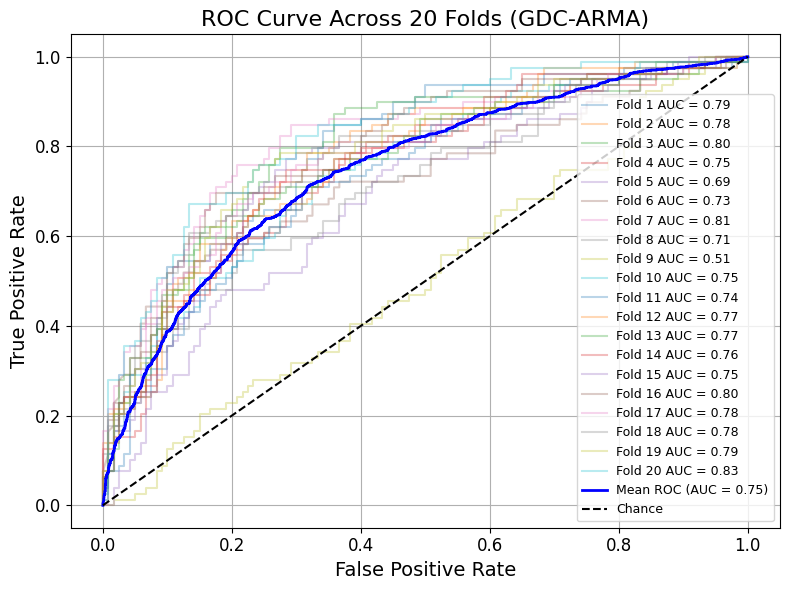

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC Curve Across 20 Folds (GDC-ARMA)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()

Training fold 1
Accuracy: 0.7593
Precision: 0.7742
Recall: 0.8000
F1 Score: 0.7869
Cross-Entropy Loss: 0.7620
AUC: 0.8188
--------------------------------------------------

Training fold 2
Accuracy: 0.7778
Precision: 0.7922
Recall: 0.8133
F1 Score: 0.8026
Cross-Entropy Loss: 0.7515
AUC: 0.8283
--------------------------------------------------

Training fold 3
Accuracy: 0.7481
Precision: 0.7628
Recall: 0.7933
F1 Score: 0.7778
Cross-Entropy Loss: 0.8515
AUC: 0.8051
--------------------------------------------------

Training fold 4
Accuracy: 0.7741
Precision: 0.7947
Recall: 0.8000
F1 Score: 0.7973
Cross-Entropy Loss: 0.8739
AUC: 0.8252
--------------------------------------------------

Training fold 5
Accuracy: 0.7556
Precision: 0.7308
Recall: 0.8867
F1 Score: 0.8012
Cross-Entropy Loss: 1.8883
AUC: 0.7589
--------------------------------------------------

Training fold 6
Accuracy: 0.7259
Precision: 0.7794
Recall: 0.7067
F1 Score: 0.7413
Cross-Entropy Loss: 1.1288
AUC: 0.7863
--------------------------------------------------

Training fold 7
Accuracy: 0.7259
Precision: 0.7603
Recall: 0.7400
F1 Score: 0.7500
Cross-Entropy Loss: 1.0584
AUC: 0.8068
--------------------------------------------------

Training fold 8
Accuracy: 0.7370
Precision: 0.6946
Recall: 0.9400
F1 Score: 0.7989
Cross-Entropy Loss: 0.9002
AUC: 0.8220
--------------------------------------------------

Training fold 9
Accuracy: 0.7259
Precision: 0.8167
Recall: 0.6533
F1 Score: 0.7259
Cross-Entropy Loss: 1.2721
AUC: 0.7741
--------------------------------------------------

Training fold 10
Accuracy: 0.7704
Precision: 0.7558
Recall: 0.8667
F1 Score: 0.8075
Cross-Entropy Loss: 0.9017
AUC: 0.8379
--------------------------------------------------

Training fold 11
Accuracy: 0.7630
Precision: 0.8162
Recall: 0.7400
F1 Score: 0.7762
Cross-Entropy Loss: 0.8617
AUC: 0.8298
--------------------------------------------------

Training fold 12
Accuracy: 0.7630
Precision: 0.7500
Recall: 0.8600
F1 Score: 0.8012
Cross-Entropy Loss: 0.8652
AUC: 0.8265
--------------------------------------------------

Training fold 13
Accuracy: 0.7667
Precision: 0.7636
Recall: 0.8400
F1 Score: 0.8000
Cross-Entropy Loss: 1.1218
AUC: 0.8096
--------------------------------------------------

Training fold 14
Accuracy: 0.7111
Precision: 0.7535
Recall: 0.7133
F1 Score: 0.7329
Cross-Entropy Loss: 0.9840
AUC: 0.7809
--------------------------------------------------

Training fold 15
Accuracy: 0.7926
Precision: 0.7866
Recall: 0.8600
F1 Score: 0.8217
Cross-Entropy Loss: 0.7764
AUC: 0.8524
--------------------------------------------------

Training fold 16
Accuracy: 0.7741
Precision: 0.7834
Recall: 0.8200
F1 Score: 0.8013
Cross-Entropy Loss: 1.0886
AUC: 0.8096
--------------------------------------------------

Training fold 17
Accuracy: 0.7852
Precision: 0.7738
Recall: 0.8667
F1 Score: 0.8176
Cross-Entropy Loss: 0.8799
AUC: 0.8071
--------------------------------------------------

Training fold 18
Accuracy: 0.7630
Precision: 0.7867
Recall: 0.7867
F1 Score: 0.7867
Cross-Entropy Loss: 1.0856
AUC: 0.8238
--------------------------------------------------

Training fold 19
Accuracy: 0.7444
Precision: 0.7314
Recall: 0.8533
F1 Score: 0.7877
Cross-Entropy Loss: 1.2426
AUC: 0.7740
--------------------------------------------------

Training fold 20
Accuracy: 0.7074
Precision: 0.7152
Recall: 0.7867
F1 Score: 0.7492
Cross-Entropy Loss: 0.8489
AUC: 0.7982
--------------------------------------------------

Average Results across 20 folds:
Accuracy: 0.7535 ± 0.0238
Precision: 0.7661 ± 0.0306
Recall: 0.8063 ± 0.0681
F1 Score: 0.7832 ± 0.0276
Cross-Entropy Loss: 1.0072 ± 0.2522
AUC: 0.8088 ± 0.0234
